# Cumprimento das atividades do segundo notebook conforme tasks/CP1.txt

Faremos novamente a clusterização com k=5, utilizando as features de ano e gênero.

In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.sparse import hstack, csr_matrix
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\José\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [280]:
# Processamentos comuns ao notebook anterior
df = pd.read_csv("data/imdb_top250.csv")
df["genre"] = df["genre"].str.split(",").str[0].str.strip()
df['sinopse'] = df['sinopse'].str.lower()
df['sinopse'].head()
stopwords = nltk.corpus.stopwords.words('portuguese')
df['sinopse_no_stopwords'] = df['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

## Obtendo X

TF-IDF das sinopses sem stopwords

In [281]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=0.05, max_df=0.95, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df['sinopse_no_stopwords'])


One-hot dos gêneros, em que cada coluna indica se o filme pertence a um determinado gênero

In [282]:
genre_cols = ['genre'] 
df_processed = pd.get_dummies(df, columns=genre_cols)
X_genre = df_processed[[col for col in df_processed.columns if col.startswith('genre_')]].values


One-hot da binagem dos anos, que agrupa os filmes em intervalos de anos, transformando em variáveis categóricas

In [283]:
bins = [1920, 1950, 1970, 1980, 1990, 2000, 2010, 2020, 2025]
labels = [0,1,2,3,4,5,6,7]

df_processed['year_bin'] = pd.cut(df_processed['year'], bins=bins, labels=labels, right=False)

df_processed = pd.get_dummies(df_processed, columns=['year_bin'])
year_cols = [col for col in df_processed.columns if col.startswith('year_bin_')]
X_year = df_processed[year_cols].values


Transformando arrays densos em sparse matrices para concatenar eficientemente

In [284]:

X_genre_sparse = csr_matrix(X_genre)
X_year_sparse = csr_matrix(X_year)

# TF-IDF
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())

# TF-IDF + gênero
X_tfidf_genre = hstack([X_tfidf, X_genre_sparse])
X_tfidf_genre_df = pd.DataFrame(X_tfidf_genre.toarray())

# TF-IDF + gênero + ano
X_full = hstack([X_tfidf, X_genre_sparse, X_year_sparse])
X_full_df = pd.DataFrame(X_full.toarray())


# Fit do Pycaret sem especificar número de clusters

In [285]:
from pycaret.clustering import setup, create_model, assign_model, plot_model, evaluate_model

def run_pycaret(X_df, session_id=42, n_clusters=5):
    # Configuração do PyCaret
    clu_setup = setup(
        data=X_df,
        session_id=session_id,
        verbose=False
    )
    
    # Criando modelos com número limitado de clusters
    kmeans = create_model('kmeans', num_clusters=n_clusters)
    hierarchical = create_model('hclust', num_clusters=n_clusters)

    
    return kmeans, hierarchical

# TF-IDF
k_t, h_t = run_pycaret(X_tfidf_df)

# TF-IDF + gênero
k_tg, h_tg = run_pycaret(X_tfidf_genre_df)

# TF-IDF + gênero + ano
k_full, h_full = run_pycaret(X_full_df)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3499,31.9546,1.3689,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3427,28.9571,1.2684,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2817,38.9582,1.7030,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3230,46.1413,1.6262,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1327,19.5027,2.3197,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1532,22.0288,2.3834,0,0,0


Considerando Silhouette + CH + DB, o cluster com Silhouette ~0.35, CH ~46, DB ~1.626 parece ser o mais equilibrado.

Trata-se de uma clusterização hierárquica sobre o dataset de TF-IDF + gênero.

In [286]:
best_model = h_tg
df_clusters = assign_model(best_model)
df['cluster'] = df_clusters['Cluster'].str.extract('(\d+)').astype(int)
df.head()

,title,year,rating,genre,sinopse,sinopse_no_stopwords,cluster
0,Um Sonho de Liberdade,1994,9.3,Drama,dois homens presos se reúnem ao longo de vário...,"dois homens presos reúnem longo vários anos, e...",1
1,O Poderoso Chefão,1972,9.2,Policial,o patriarca idoso de uma dinastia do crime org...,patriarca idoso dinastia crime organizado tran...,3
2,Batman: O Cavaleiro das Trevas,2008,9.1,Ação,agora com a ajuda do tenente jim gordon e do p...,agora ajuda tenente jim gordon promotor públic...,2
3,O Poderoso Chefão: Parte II,1974,9.0,Policial,o início da vida e da carreira de vito corleon...,início vida carreira vito corleone década 1920...,3
4,12 Homens e uma Sentença,1957,9.0,Policial,o julgamento de um assassinato em nova iorque ...,julgamento assassinato nova iorque frustrado ú...,3


## Filmes por cluster

In [287]:
fig = px.bar(df.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

## % de Gêneros por Cluster

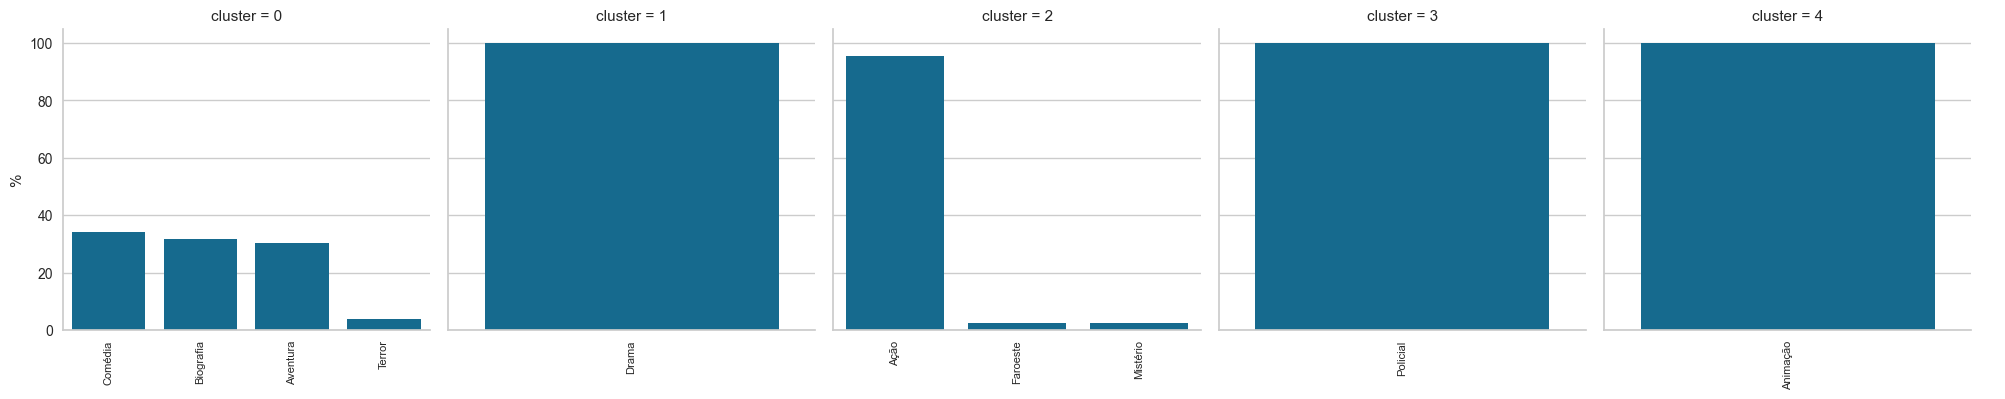

In [288]:
df_plot = df.groupby(['cluster', 'genre'])['title'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

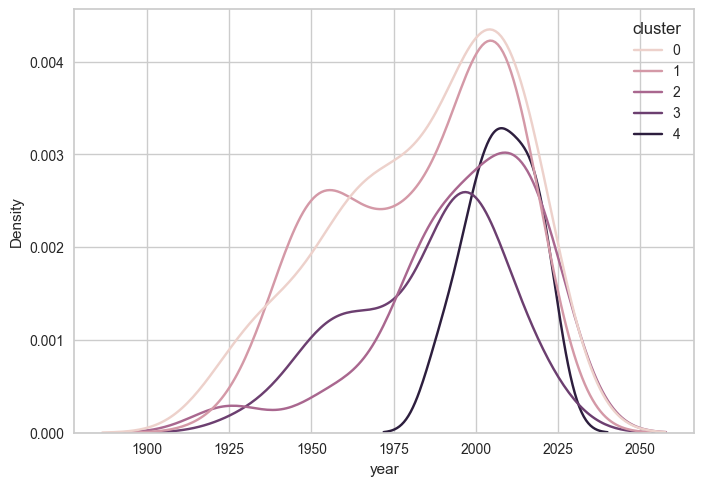

In [289]:
sns.kdeplot(df, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [290]:

df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'genre', columns = 'cluster', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

genre,cluster,Animação,Aventura,Ação,Biografia,Comédia,Drama,Faroeste,Mistério,Policial,Terror
0,0,0.0,30.263158,0.000000,31.578947,34.210526,0.0,0.000000,0.000000,0.0,3.947368
1,1,0.0,0.000000,0.000000,0.000000,0.000000,100.0,0.000000,0.000000,0.0,0.000000
2,2,0.0,0.000000,95.348837,0.000000,0.000000,0.0,2.325581,2.325581,0.0,0.000000
3,3,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.0,0.000000
4,4,100.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


# Nuvem de Palavras por Cluster

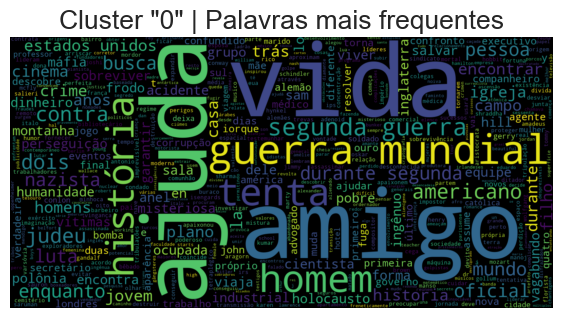

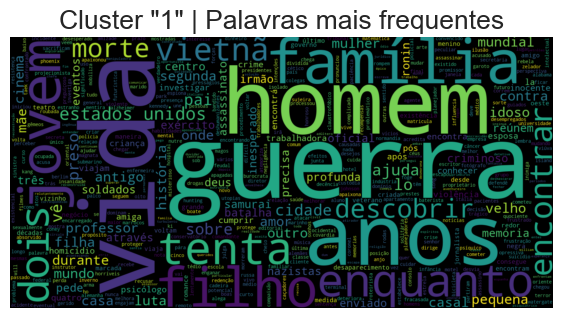

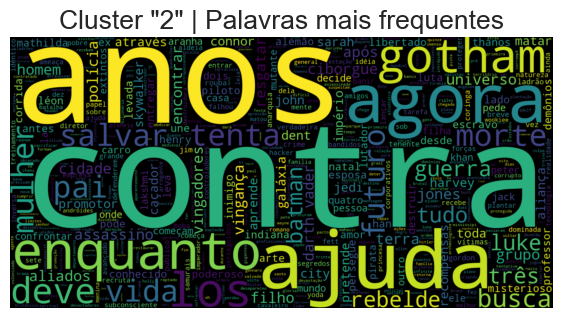

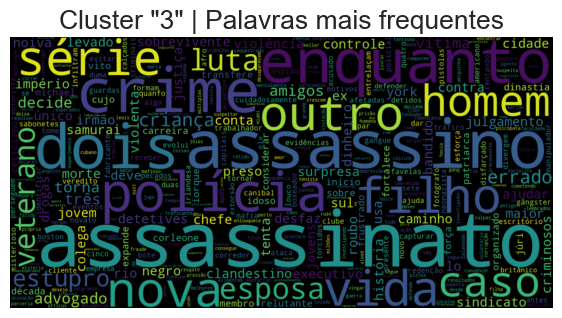

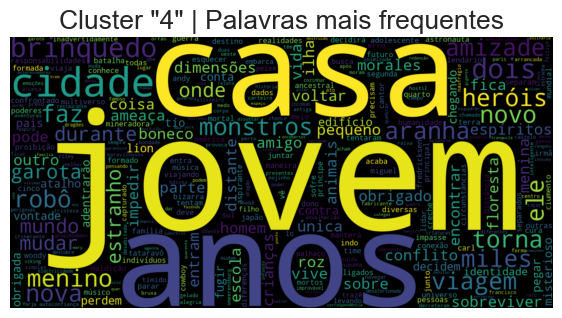

In [291]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df.loc[df.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

for c in range(5):
  word_cloud_cluster(c)

In [292]:
from collections import Counter
import pandas as pd

def top_words_cluster(cluster:int, n:int=7):
    # Junta todas as sinopses do cluster
    text = ' '.join(df.loc[df.cluster == cluster, 'sinopse_no_stopwords'])
    # Conta a frequência das palavras
    word_counts = Counter(text.split())
    # Pega as n mais comuns
    top_words = word_counts.most_common(n)
    # Retorna como DataFrame para ficar organizado
    df_top = pd.DataFrame(top_words, columns=["palavra", "frequencia"])
    return df_top

# Gerar tabelas para todos os clusters
clusters_top_words = {c: top_words_cluster(c) for c in range(5)}
for c in range(5):
    print(f"\nCluster {c} - Top palavras:")
    print(top_words_cluster(c))



Cluster 0 - Top palavras:
   palavra  frequencia
0   guerra          10
1    ajuda           8
2     vida           8
3  durante           7
4  segunda           7
5    homem           7
6    tenta           7

Cluster 1 - Top palavras:
    palavra  frequencia
0     homem           9
1      vida           9
2    guerra           8
3      anos           7
4     jovem           6
5  enquanto           6
6     tenta           6

Cluster 2 - Top palavras:
    palavra  frequencia
0    contra           9
1     ajuda           7
2  enquanto           5
3     agora           4
4    gotham           4
5      deve           4
6      anos           4

Cluster 3 - Top palavras:
       palavra  frequencia
0  assassinato           6
1     enquanto           5
2         dois           5
3    assassino           5
4         nova           4
5        homem           4
6         caso           4

Cluster 4 - Top palavras:
    palavra  frequencia
0     jovem           8
1      anos           4
2      do

# Comparação com o modelo sem as features adicionais

## 1) Balanceamento

Observa-se que o novo modelo apresenta uma distribuição de amostras mais equilibrada em relação ao primeiro modelo, ainda que não tão homogênea quanto a clusterização anterior mais refinada. O cluster 0 conta com 76 filmes, o cluster 1 com 69, o cluster 2 com 43, o cluster 3 com 36 e o cluster 4 com 26. Embora não haja um cluster dominante que absorva a maior parte das amostras, nota-se que os clusters menores continuam relativamente reduzidos, indicando que a granularidade ainda poderia ser ajustada para capturar melhor a diversidade do conjunto.

## 2) Distribuição dos gêneros

Cluster 0 
Predominância de Biografia (31,6%), Comédia (34,2%) e Aventura (30,3%), sugerindo um perfil híbrido que mistura narrativas de entretenimento leve com elementos históricos ou biográficos.

Cluster 1 
Totalmente centrado em Drama (100%), refletindo uma clusterização muito homogênea em termos de gênero, com foco em histórias sérias e emotivas.

Cluster 2 
Forte presença de Ação (95,3%), com pequenas incidências de Faroeste e Mistério (2,3% cada). Trata-se de filmes com foco em aventura, combates e narrativa dinâmica.

Cluster 3 
Completamente voltado para Policial (100%), indicando um agrupamento muito específico, provavelmente orientado por conflitos e investigações.

Cluster 4 
Inteiramente Animação (100%), representando o perfil mais claramente definido do conjunto.

Observa-se que, diferentemente do modelo anterior, os clusters agora apresentam uma definição de gênero mais nítida, com cada agrupamento capturando categorias específicas, ainda que alguns clusters (como o 0) misturem gêneros correlatos. A presença de sinopses como feature permitiu separar os agrupamentos tematicamente, mas a ausência de informações temporais impede uma distribuição temporal mais contextualizada.

## 3) Distribuição temporal

Sem a utilização do ano de lançamento como feature, a clusterização voltou a apresentar uma homogeneidade temporal semelhante ao primeiro modelo, com todos os clusters concentrados em torno de períodos próximos ao ano 2000. Essa uniformidade evidencia que, apesar da melhora na segmentação por gênero e temática, a dimensão temporal dos filmes não é capturada, reduzindo a capacidade do modelo de refletir tendências históricas ou evoluções narrativas.

## 4) Nuvens de palavras

Cluster 0 
Destaca palavras como guerra, ajuda, vida, durante, segunda, homem e tenta, sugerindo narrativas relacionadas a conflitos históricos e trajetórias pessoais marcadas por adversidades.

Cluster 1 
Apresenta termos como homem, vida, guerra, anos, jovem, enquanto e tenta, evidenciando dramas humanos e histórias de crescimento ou superação.

Cluster 2 
Foca em contra, ajuda, enquanto, agora, gotham, deve e anos, revelando enredos de ação e combate, com menções específicas a universos ficcionais urbanos.

Cluster 3 
Traz assassinato, enquanto, dois, assassino, nova, homem e caso, refletindo tramas criminais e investigações, coerentes com o perfil policial do cluster.

Cluster 4 
Evidencia jovem, anos, dois, monstros, casa, miles e novo, indicando narrativas voltadas para animação, aventuras e fantasia, centradas em personagens jovens ou universos ficcionais.

As nuvens de palavras confirmam que o modelo consegue separar de maneira mais clara perfis temáticos distintos, alinhando vocabulário e gênero. No entanto, ainda há sobreposição de termos em alguns clusters (como “homem” e “vida”), indicando que elementos narrativos recorrentes podem aparecer em diferentes contextos.

# Conclusão
Comparando com os modelos anteriores, percebe-se que o novo modelo hierárquico, utilizando apenas sinopse e gênero, apresenta uma segmentação mais coerente por gênero e temática, com clusters identificáveis e top palavras que refletem bem o conteúdo narrativo. A distribuição de amostras é razoavelmente equilibrada, ainda que não perfeita, e os clusters menores capturam nichos específicos de filmes. Para um aplicativo em que o usuário escreve uma sinopse e espera receber recomendações, este modelo é preferível, pois garante que as recomendações reflitam mais fielmente o tipo de narrativa desejado, priorizando similaridade temática e de gênero ao invés de fatores temporais ou de popularidade.

In [ ]:
import pickle

with open("../models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
df.to_csv("../data/imdb_top250_clusters.csv", index=False)
